In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as patches
import cv2

In [2]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
COLOR = [(0,255,255),(227,207,87),(0,100,0),(191,62,255),(255,127,36),(238,59,59),(0,0,139),(138,54,15),(255,211,155),(71,60,139)]
# config file 들고오기
exp_num = "exp15"
cfg = Config.fromfile(f'./configs/_custom/{exp_num}/cascade_rcnn_ep100.py')

root='../../dataset/'

epoch = 'best_bbox_mAP_50_epoch_11'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'valid_set.json'
# cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = f'./work_dirs/{exp_num}/'

# cfg.model.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [3]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [4]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

load checkpoint from local path: ./work_dirs/exp15/best_bbox_mAP_50_epoch_11.pth


In [5]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 817/817, 2.0 task/s, elapsed: 409s, ETA:     0s

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
../../dataset/train/4143.jpg


<function matplotlib.pyplot.show(close=None, block=None)>

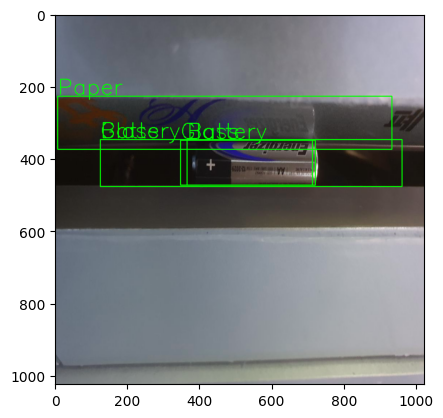

In [9]:
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()
class_num = 10
# print(output[0][0])
# print(len(output[2]))
index = 3
dataPath = '../../dataset/'

i = img_ids[index]
out = output[index]
image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
img_test = cv2.imread(dataPath+image_info['file_name'])
# img_test = cv2.resize(img_test, (512,512))

print(dataPath+image_info['file_name'])
for j in range(class_num):
    for o in out[j]:
        x_max,y_max = int(o[2]), int(o[3])
        x_min,y_min = int(o[0]), int(o[1])
        cf_score = o[4]

        img_test = cv2.rectangle(img_test, (x_min,y_min), (x_max,y_max), (0,255,0), 2) #(x1,y1) (x2,y2)
        img_test = cv2.putText(img_test, classes[j], (x_min,y_min-5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2)
        
plt.imshow(img_test)
plt.show

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<function matplotlib.pyplot.show(close=None, block=None)>

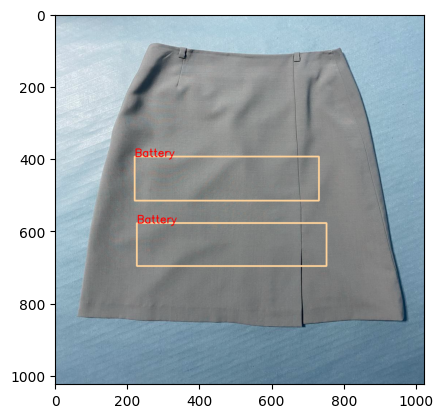

In [8]:
coco = COCO(cfg.data.test.ann_file)
dataPath = '../../dataset/'


label_index = coco.getCatIds()
ann_index = coco.getAnnIds(catIds=label_index)

img_ids = coco.getImgIds()
image_infos = coco.loadImgs(img_ids)

index = 0

print(image_infos[index]['file_name'],end='\r')

ann_ids = coco.getAnnIds(imgIds=image_infos[index]['id'])
img = cv2.imread(dataPath+image_info['file_name'])

for ann in coco.loadAnns(ann_ids):
    x_mn,x_mx = ann['bbox'][0], ann['bbox'][0] + ann['bbox'][2]
    y_mn,y_mx = ann['bbox'][1], ann['bbox'][1] + ann['bbox'][3]
    
    img = cv2.rectangle(img,(int(x_mn),int(y_mn)),(int(x_mx),int(y_mx)),color=COLOR[ann['category_id']],thickness=4)
    img = cv2.putText(img,classes[ann['category_id']],(int(x_mn),int(y_mn)),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
        
plt.imshow(img)
plt.show
        